In [ ]:
#Installing few packages
!pip install pyoptflow
!pip install lpips
!pip install imageio[ffmpeg]

In [ ]:
from matplotlib import pyplot as plt
from pyoptflow import HornSchunck
import numpy as np
import cv2
import glob
import re
import imageio
import os
import torch
import lpips
import math


In [ ]:
#upload zip file
from google.colab import files
uploaded_zip = files.upload()

Saving 00001.zip to 00001.zip


In [ ]:
#unzip the file
import zipfile
with zipfile.ZipFile('00001.zip','r') as zip_ref:
  zip_ref.extractall('Images1')

In [ ]:
#Function to make the list of frames
def load_frames_from_folder(folder_path):
    frames = []
    for filename in sorted(os.listdir(folder_path)):
        frame = imageio.imread(os.path.join(folder_path, filename))
        frames.append(frame)
    return frames

#Function for creating repeating frame video for reference
def repeat_frames(frames, K):
    repeated_frames = []
    for frame in frames:
        repeated_frames.extend([frame] * K)
    final_frame = repeated_frames[0:-K+1]
    return final_frame

#Function to create vidoe
def create_video_from_frames(frames, output_file,frame_rate):
    imageio.mimsave(output_file, frames, format='mp4',fps=frame_rate)

#Function for Warping
def warping(input_frame, flow_x, flow_y):
    x, y = np.float32(np.meshgrid(np.arange(input_frame.shape[1]), np.arange(input_frame.shape[0])))
    x1, y1 = np.float32(x + flow_x), np.float32(y + flow_y)
    warped_image = cv2.remap(input_frame, x1, y1, interpolation=cv2.INTER_CUBIC)
    return warped_image

#Function to calculate multiscale Optical Flow
def optical_flow_multiscale(frame1_rgb, frame2_rgb, num_levels, alpha, num_iterations ):

    #RGB to grayscale conversion
    frame1 = cv2.cvtColor(frame1_rgb, cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(frame2_rgb, cv2.COLOR_BGR2GRAY)
    frame1_reference = frame1.copy()
    frame2_reference = frame2.copy()

    u_levels = []
    v_levels = []
    frame_levels = []

    #Create arrays for multiscale frames
    frame1_multiscale = np.empty((frame1.shape[0], frame1.shape[1], num_levels))
    frame2_multiscale = np.empty((frame2.shape[0], frame2.shape[1], num_levels))
    frame1_multiscale[:, :, 0] = frame1
    frame2_multiscale[:, :, 0] = frame2

    #Generate multiscale frames by downsampling
    for level in range(1, num_levels):
        frame1 = cv2.pyrDown(frame1)
        frame2 = cv2.pyrDown(frame2)
        frame1_multiscale[0 : frame1.shape[0], 0 : frame1.shape[1], level] = frame1
        frame2_multiscale[0 : frame2.shape[0], 0 : frame2.shape[1], level] = frame2

    #Compute optical flow at the lowest resolution level (level0)
    level0 = num_levels - 1
    level0_scale = 2 ** level0
    frame1_level0 = frame1_multiscale[0:(len(frame1_multiscale[:,0])//level0_scale),
                                      0:(len(frame1_multiscale[0,:])//level0_scale),level0]
    frame2_level0 = frame2_multiscale[0:(len(frame2_multiscale[:,0])//level0_scale),
                                      0:(len(frame2_multiscale[0,:])//level0_scale),level0]

    #Compute optical flow using Horn-Schunck at level0 and refine it iteratively
    flow_x, flow_y = HornSchunck(frame1_level0, frame2_level0, alpha=0.1, Niter=100)
    flow_x_for, flow_y_for = -flow_x, -flow_y

    #Append the initial flow vectors, as well as the reference frame to the lists
    u_levels.append(flow_x_for.copy())
    v_levels.append(flow_y_for.copy())
    frame_levels.append(frame1_level0.copy())

    #Compute optical flow at other levels of the pyramid and refine iteratively
    for k in range(1, num_levels):

        #Upsample the flow vectors from the previous level
        upsampled_flow_x = cv2.pyrUp(flow_x_for)
        upsampled_flow_y = cv2.pyrUp(flow_y_for)
        levelk = num_levels - k - 1
        levelk_scale = 2 ** levelk

        #Get frames at the intermediate level
        frame1_intermediate = frame1_multiscale[0:(len(frame1_multiscale[:,0])//levelk_scale),
                                                0:(len(frame1_multiscale[0,:])//levelk_scale),levelk]
        frame2_intermediate = frame2_multiscale[0:(len(frame2_multiscale[:,0])//levelk_scale),
                                                0:(len(frame2_multiscale[0,:])//levelk_scale),levelk]

        #Warp the intermediate frame using the upsampled flow vectors
        frame1_intermediate_wr = warping(frame1_intermediate, upsampled_flow_x, upsampled_flow_y)

        #Compute optical flow using Horn-Schunck at the intermediate level and refine it iteratively
        flow_x, flow_y = HornSchunck(frame1_intermediate_wr, frame2_intermediate, alpha=0.1, Niter=100)
        flow_x_for, flow_y_for = -flow_x, -flow_y

        # Add the upsampled flow vectors to the current flow vectors
        flow_x_for = upsampled_flow_x + flow_x_for
        flow_y_for = upsampled_flow_y + flow_y_for

    return (flow_x_for, flow_y_for)

#Funtion to get forward optical flow
def get_forward_optical_flow(frame1,frame2,flow,k,K):

    #Forward Flow calculation
    interpolation_factor = k / K
    interpolated_flow_x = flow[0] * interpolation_factor
    interpolated_flow_y = flow[1] * interpolation_factor

    #Forward interpolation
    height, width, color = frame1.shape
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    remapped_x = x_coords + interpolated_flow_x
    remapped_y = y_coords + interpolated_flow_y
    interpolated_frame_forward = cv2.remap(frame1, remapped_x.astype(np.float32),
                                           remapped_y.astype(np.float32), interpolation=cv2.INTER_LINEAR)

    return interpolated_frame_forward

#Funtion to get backward optical flow
def get_backward_optical_flow(frame1, frame2,flow,k,K):

    #Backward optical flow calculation
    flow_0 =  -np.asarray(flow[0])
    flow_1 =  -np.asarray(flow[1])
    interpolation_factor = k / K
    interpolated_flow_x = flow_0 * interpolation_factor
    interpolated_flow_y = flow_1 * interpolation_factor

    #Backward interpolation
    height, width,color = frame1.shape
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    remapped_x = x_coords + interpolated_flow_x
    remapped_y = y_coords + interpolated_flow_y
    interpolated_frame_backward = cv2.remap(frame2, remapped_x.astype(np.float32),
                                            remapped_y.astype(np.float32), interpolation=cv2.INTER_LINEAR)
    return interpolated_frame_backward

#Function for frame interpolation with K frames using forward and backward optical flow
def interpolate_frames(frames, optical_flow, K):

    if len(frames) != len(optical_flow) + 1:
        raise ValueError("The number of frames and optical flow fields should match.")

    interpolated_frames = []
    for i in range(len(frames) - 1):
        frame1 = frames[i]
        frame2 = frames[i + 1]
        flow = optical_flow[i]
        interpolated_frames.append(frame1)

        for k in range(1, K):
            interpolated_frame_backward = get_backward_optical_flow(frame1, frame2,flow,k,K)
            interpolated_frame_backward = (interpolated_frame_backward).astype(np.uint8)

            interpolated_frame_forward = get_backward_optical_flow(frame1, frame2,flow,k,K)
            interpolated_frame_forward = (interpolated_frame_forward).astype(np.uint8)

            #Few heuristics to deal with the pixels which do not map to any location
            #either the forward or the backward frame

            #Replace unmapped pixels with the maximum value from the other image
            zero_mask = (interpolated_frame_forward == 0) | (interpolated_frame_backward == 0)
            interpolated_frame1 = np.where(zero_mask, np.maximum(
                interpolated_frame_forward, interpolated_frame_backward),interpolated_frame_forward)

            #Copy the frame2 pixel value to the remaining unmatched pixel values in interpolated frame
            final_interpolated_frame=np.where(interpolated_frame1 == 0, frames[i+1],interpolated_frame1)
            interpolated_frames.append(final_interpolated_frame)

    interpolated_frames.append(frames[-1])
    return interpolated_frames

#Function for calculating PSNR
def calculate_psnr(frame1, frame2):
    mse = np.mean((frame1 - frame2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

#Function for calculating average PSNR for entire video
def get_average_psnr(frames_list1,frames_list2):
    psnr_scores = []

    #PSNR calculation
    for frame1, frame2 in zip(frames_list1, frames_list2):

        #Ensure that frames_list1 and frames_list2 have the same length
        if frame1.shape != frame2.shape:
            raise ValueError("Frames must have the same dimensions.")
        psnr = calculate_psnr(frame1, frame2)
        psnr_scores.append(psnr)

    # Calculate the average PSNR score for valid scores
    valid_psnr_scores = [score for score in psnr_scores if not math.isinf(score)]
    if len(valid_psnr_scores) > 0:
        average_psnr = sum(valid_psnr_scores) / len(valid_psnr_scores)
    else:
        average_psnr = 0.0
    return average_psnr

#Function to get average LPIPS
def get_average_lpips(frames_list1,frames_list2):

    #Load pre-trained LPIPS model
    loss_fn_alex = lpips.LPIPS(net='alex', verbose=0)
    lpips_scores = []
    average_lpips = 0.0

    #Ensure that frames_list1 and frames_list2 have the same length
    if len(frames_list1) != len(frames_list2):
        raise ValueError("Both lists must have the same number of frames.")

    #Calculate LPIPS for each frame pair
    for frame1, frame2 in zip(frames_list1, frames_list2):
        tensor1 = torch.from_numpy(frame1).permute(2, 0, 1).unsqueeze(0).float()
        tensor2 = torch.from_numpy(frame2).permute(2, 0, 1).unsqueeze(0).float()
        lpips_score = loss_fn_alex(tensor1, tensor2).item()
        lpips_scores.append(lpips_score)

    #Calculate the average LPIPS score for frames having lpips score > 0
    non_zero_lpips_scores = [score for score in lpips_scores if score > 0]
    if len(non_zero_lpips_scores) > 0:
        average_lpips = sum(non_zero_lpips_scores) / len(non_zero_lpips_scores)
    else:
        average_lpips = 0.0
    return average_lpips



In [ ]:
#Load frames into a list
input_folder = "/content/Images1/00001/rgb"
frames = load_frames_from_folder(input_folder)
frame_rate =  15


In [ ]:
#Define the range of num_levels and K values to iterate over
num_levels_values = [3, 4, 5]
K_values = [2, 3, 4]

#Iterate over different num_levels and get list of optical flow
list_of_interpolated_frame_list = []
list_of_repeated_frame_list = []

for num_levels in num_levels_values:
    optical_flow_list = []
    for i in range(len(frames) - 1):
            frame1 = frames[i]
            frame2 = frames[i + 1]
            optical_flow = optical_flow_multiscale(frame1, frame2, num_levels, alpha= 0.1, num_iterations=25)
            optical_flow_list.append(optical_flow)

    #Iterate over K values for frame interpolation
    for K in K_values:
        repeated_frames_list = repeat_frames(frames, K)
        interpolated_frames_list = interpolate_frames(frames, optical_flow_list,K)
        list_of_interpolated_frame_list.append(interpolated_frames_list)
        list_of_repeated_frame_list.append(repeated_frames_list)

        #Calculating LPIPS and PSNR for each video
        lpips_score = get_average_lpips(repeated_frames_list, interpolated_frames_list)
        psnr_score = get_average_psnr(repeated_frames_list, interpolated_frames_list)

        # Save the interpolated video as a new video file
        interpolated_video_name = f"interpolated_video_S{num_levels}_K{K}.mp4"
        repeated_video_name = f"repeated_video_S{num_levels}_K{K}.mp4"

        create_video_from_frames(repeated_frames_list, interpolated_video_name,frame_rate*K)
        create_video_from_frames(interpolated_frames_list, interpolated_video_name,frame_rate*K)

        # Print or save the results as needed
        print(f"Num Levels: {num_levels}, K: {K}")
        print(f"LPIPS Scores: {lpips_score}")
        print(f"PSNR Scores: {psnr_score}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Num Levels: 3, K: 2
LPIPS Scores: 0.019761875423849846
PSNR Scores: 37.889370485844196
Num Levels: 3, K: 3
LPIPS Scores: 0.019133704914046184
PSNR Scores: 37.92632340154894
Num Levels: 3, K: 4
LPIPS Scores: 0.018868436834135024
PSNR Scores: 37.94087780623255
Num Levels: 4, K: 2
LPIPS Scores: 0.020819204764402643
PSNR Scores: 37.882538245775564
Num Levels: 4, K: 3
LPIPS Scores: 0.020202437244659782
PSNR Scores: 37.9248107092083
Num Levels: 4, K: 4
LPIPS Scores: 0.020145671464325415
PSNR Scores: 37.95125212311383
Num Levels: 5, K: 2
LPIPS Scores: 0.022234640597384805
PSNR Scores: 37.86755282795768
Num Levels: 5, K: 3
LPIPS Scores: 0.021635939234069416
PSNR Scores: 37.928932266718704
Num Levels: 5, K: 4
LPIPS Scores: 0.02138949850840228
PSNR Scores: 37.94932668196157


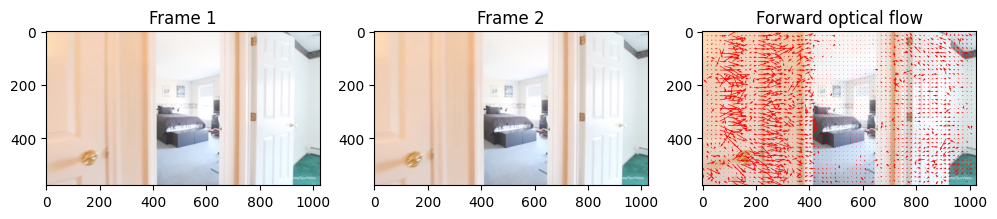

In [ ]:
#Visualizing optical flow
flow_x, flow_y = optical_flow
frame1 = frames[-2]
frame2 = frames[-1]

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(frame1, cmap='gray')
plt.title('Frame 1')

plt.subplot(1, 3, 2)
plt.imshow(frame2, cmap='gray')
plt.title('Frame 2')

# Forward Optical Flow
plt.subplot(1, 3, 3)
plt.imshow(frame1, cmap='gray')
plt.title('Forward optical flow')

step = 16  # Step size for visualization
plt.quiver(
    np.arange(0, flow_y.shape[1], step),
    np.arange(0, flow_x.shape[0], step),
    flow_x[::step, ::step],
    flow_y[::step, ::step],
    color='r'
)
plt.show()